### 3.2.5. Summary
To highlight the object-oriented design for our future deep learning implementation, the above classes simply show how their objects store data and interact with each other. We will keep enriching implementations of these classes, such as via @add_to_class, in the rest of the book. Moreover, these fully implemented classes are saved in the [D2L library](https://github.com/d2l-ai/d2l-en/tree/master/d2l), a lightweight toolkit that makes structured modeling for deep learning easy. In particular, it facilitates reusing many components between projects without changing much at all. For instance, we can replace just the optimizer, just the model, just the dataset, etc.; this degree of modularity pays dividends throughout the book in terms of conciseness and simplicity (this is why we added it) and it can do the same for your own projects.

## 3.2. Object-Oriented Design for Implementation

In [ ]:
#https://colab.research.google.com/github/d2l-ai/d2l-pytorch-colab/blob/master/chapter_linear-regression/linear-regression.ipynb

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

%matplotlib inline
import math
import time
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

2024-02-12 15:57:26.257119: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 15:57:26.257149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 15:57:26.257964: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 15:57:26.263339: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 15:57:26.971848: W tensorflow/compiler/tf2

In [4]:
#pip install d2l==1.0.3

### 3.1.2. Vectorization for Speed

In [5]:
n = 10000
a = tf.ones(n)
b = tf.ones(n)

In [6]:
c = tf.Variable(tf.zeros(n))
t = time.time()
for i in range(n):
    c[i].assign(a[i] + b[i])
f'{time.time() - t:.5f} sec'

'6.19694 sec'

In [7]:
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.00035 sec'

The second method is dramatically faster than the first. Vectorizing code often yields order-of-magnitude speedups. Moreover, we push more of the mathematics to the library so we do not have to write as many calculations ourselves, reducing the potential for errors and increasing portability of the code.

### 3.2.1. Utilities
We need a few utilities to simplify object-oriented programming in Jupyter notebooks. One of the challenges is that class definitions tend to be fairly long blocks of code. Notebook readability demands short code fragments, interspersed with explanations, a requirement incompatible with the style of programming common for Python libraries. The first utility function allows us to register functions as methods in a class after the class has been created. In fact, we can do so even after we have created instances of the class! It allows us to split the implementation of a class into multiple code blocks.

In [8]:
def add_to_class(Class):  #@save
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

Let’s have a quick look at how to use it. We plan to implement a class A with a method do. Instead of having code for both A and do in the same code block, we can first declare the class A and create an instance a.

In [16]:
class A:
    def __init__(self):
        self.b = 1

a = A()

Next we define the method do as we normally would, but not in class A’s scope. Instead, we decorate this method by add_to_class with class A as its argument. In doing so, the method is able to access the member variables of A just as we would expect had it been included as part of A’s definition. Let’s see what happens when we invoke it for the instance a.

In [17]:
@add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)

a.do()

Class attribute "b" is 1


The second one is a utility class that saves all arguments in a class’s __init__ method as class attributes. This allows us to extend constructor call signatures implicitly without additional code.

In [18]:
class HyperParameters:  #@save
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        raise NotImplemented

We defer its implementation into Section 23.7. To use it, we define our class that inherits from HyperParameters and calls save_hyperparameters in the *__init__* method.

In [12]:
class B(d2l.HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = True


The final utility allows us to plot experiment progress interactively while it is going on. In deference to the much more powerful (and complex) TensorBoard we name it ProgressBoard. The implementation is deferred to Section 23.7. For now, let’s simply see it in action.

The draw method plots a point (x, y) in the figure, with label specified in the legend. The optional every_n smooths the line by only showing 1/n points in the figure. Their values are averaged from the 
 neighbor points in the original figure.

In [13]:
class ProgressBoard(d2l.HyperParameters):  #@save
    """The board that plots data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

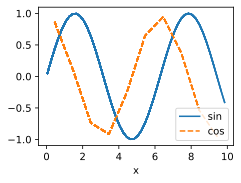

In [15]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

### 3.2.3. Data
The DataModule class is the base class for data. Quite frequently the __init__ method is used to prepare the data. This includes downloading and preprocessing if needed. The train_dataloader returns the data loader for the training dataset. A data loader is a (Python) generator that yields a data batch each time it is used. This batch is then fed into the training_step method of Module to compute the loss. There is an optional val_dataloader to return the validation dataset loader. It behaves in the same manner, except that it yields data batches for the validation_step method in Module.

In [22]:
class DataModule(d2l.HyperParameters):  #@save
    """The base class of data."""
    def __init__(self, root='../data'):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

### 3.2.4. Training

The Trainer class trains the learnable parameters in the Module class with data specified in DataModule. The key method is fit, which accepts two arguments: model, an instance of Module, and data, an instance of DataModule. It then iterates over the entire dataset max_epochs times to train the model. As before, we will defer the implementation of this method to later chapters.

In [24]:
class Trainer(d2l.HyperParameters):  #@save
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError